In [90]:
# Imports
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix, auc, roc_curve, roc_auc_score, average_precision_score

# from imblearn.over_sampling import RandomOverSampler, SMOTE

# measuring fairness
from fairlearn.metrics import (
    count,
    demographic_parity_difference,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
    MetricFrame,
    make_derived_metric,
    selection_rate,  
)
from sklearn.metrics import precision_score
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

from random import sample


import warnings
warnings.filterwarnings("ignore")

In [91]:
adult_original = pd.read_csv('adult/Dataset.data', delimiter=' ', header=None) # read the dataset from .data file

# name the columns
adult_original.rename(columns={0: 'age', 
                      1: 'workclass', 
                      2: 'fnlwgt', 
                      3: 'education', 
                      4: 'educational-num', 
                      5: 'marital-status', 
                      6: 'occupation', 
                      7: 'relationship', 
                      8: 'race', 
                      9: 'gender', 
                      10: 'capital-gain', 
                      11: 'capital-loss', 
                      12: 'hours-per-week', 
                      13: 'native-country', 
                      14: 'income'}, inplace=True)

# change a target and a sensitive variables to 1/0
adult_original['income'] = (adult_original['income'] == '>50K').astype(int)
adult_original['gender'] = (adult_original['gender'] == 'Female').astype(int)

In [92]:
adult_original.replace("?", np.nan, inplace = True) # missing values to NaN
adult_original.isnull().sum() # count missing values

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [93]:
adult_original = adult_original.dropna().reset_index(drop=True) # drop missing values, reset index
# adult_original

In [94]:
adult_original

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,0,0,0,40,United-States,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,0,0,0,50,United-States,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,0,0,0,40,United-States,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,0,7688,0,40,United-States,1
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,0,0,0,30,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,1,0,0,38,United-States,0
45218,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,0,0,0,40,United-States,1
45219,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,1,0,0,40,United-States,0
45220,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,0,0,0,20,United-States,0


In [95]:
# adult_original['race'].value_counts()

In [96]:
# select two largest groups
# data = adult_original[(adult_original["race"] == "White") | (adult_original["race"] == "Black")]

In [97]:
# data.reset_index(drop=True)

In [98]:
data = adult_original

In [99]:
data.value_counts(['gender', 'income']).to_frame()

,,0
gender,income,
0,0,20988
1,0,13026
0,1,9539
1,1,1669


In [100]:
# by choosing y_pred to be ground truth instead of predictions, we can easily compute the base rate in the data
mf = MetricFrame(
    metrics={"base rate": selection_rate},
    y_true=data["income"],  # y_true is ignored
    y_pred=data["income"],
    sensitive_features=data["gender"],
)
display(mf.by_group)

# summarize demographic parity as the max difference between groups
print("base rate diff: %.2f" % mf.difference(method="between_groups"))

,base rate
gender,
0,0.312477
1,0.113576


base rate diff: 0.20


In [101]:
data_encoded = pd.get_dummies(data)

In [102]:
y = data['income']
X = data.drop(columns=['income'])

In [103]:
X_encoded = pd.get_dummies(X) # One-hot-encoded X

In [104]:
# Train test split
rs = 0 # Random State

trainset, testset = train_test_split(data_encoded, test_size=0.25, random_state=rs)

In [105]:
trainset['income'].sum() / len(trainset)

0.24675669300625075

In [106]:
trainset['gender'].sum() / len(trainset)

0.3263651373982781

In [107]:
# data['income'].sum() / len(data) #class imbalance

In [108]:
# data['gender'].sum() / len(data) #group imbalance

In [109]:
# smote_sampler = SMOTE(random_state=0)

In [110]:
# X_smote, y_smote = smote_sampler.fit_resample(X_encoded, y)

In [111]:
# # by choosing y_pred to be ground truth instead of predictions, we can easily compute the base rate in the data
# mf = MetricFrame(
#     metrics={"base rate": selection_rate},
#     y_true=y_smote,  # y_true is ignored
#     y_pred=y_smote,
#     sensitive_features=X_smote["gender"],
# )
# display(mf.by_group)

# # summarize demographic parity as the max difference between groups
# print("base rate diff: %.2f" % mf.difference(method="between_groups"))

In [112]:
# y_smote.sum() / len(y_smote) #class imbalance

In [113]:
# X_smote['gender'].sum() / len(X_smote) #group imbalance

In [114]:
data00 = trainset[(trainset['gender'] == 0) & (trainset['income'] == 0)]

In [115]:
data01 = trainset[(trainset['gender'] == 0) & (trainset['income'] == 1)]

In [116]:
data10 = trainset[(trainset['gender'] == 1) & (trainset['income'] == 0)]

In [117]:
data11 = trainset[(trainset['gender'] == 1) & (trainset['income'] == 1)]

In [118]:
datas = [data00, data01, data10, data11]

In [119]:
m = 0
for d in datas:
    if len(d) > m:
        m = len(d)
        df = d
df

,age,fnlwgt,educational-num,gender,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
36418,18,298860,7,0,0,0,20,0,0,0,...,0,0,0,0,0,0,0,1,0,0
13607,50,343242,10,0,0,0,55,0,0,0,...,0,0,0,0,0,0,0,1,0,0
25430,29,409201,10,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
37962,25,285367,9,0,0,0,50,0,0,0,...,0,0,0,0,0,0,0,1,0,0
21961,18,120544,5,0,0,0,15,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32230,38,175232,9,0,0,0,45,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14935,37,217054,9,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
41993,36,186110,10,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32103,32,198068,9,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [120]:
datas.remove(df)

In [121]:
len(data01)

7134

In [34]:
# for d in datas:
#     print('test')
#     while len(d) < m:
#         # print('test')
#         # print(d.sample())
#         # d = d.append(d.sample())
#         # print(len(d))
#         pass

In [35]:
while len(data01) < m - 100:
    data01 = data01.append(data01.sample(100))
while len(data01) < m:
    data01 = data01.append(data01.sample())
len(data01)

15713

In [36]:
data01

,age,fnlwgt,educational-num,gender,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
17957,41,119079,9,0,0,0,49,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1421,58,49893,14,0,0,0,50,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3960,31,112115,9,0,0,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,0
21312,31,155781,13,0,0,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,0
37425,46,353012,16,0,0,1902,50,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5023,53,141340,9,0,0,0,40,1,1,0,...,0,0,0,0,0,0,0,1,0,0
30064,41,352834,13,0,7688,0,55,1,0,0,...,0,0,0,0,0,0,0,1,0,0
43713,50,175029,9,0,0,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3417,66,74263,9,0,0,0,86,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [37]:
while len(data10) < m - 100:
    data10 = data10.append(data10.sample(n=100))
while len(data10) < m :
    data10 = data10.append(data10.sample())
len(data10)

15713

In [38]:
while len(data11) < m - 100:
    data11 = data11.append(data11.sample(n=100))
while len(data11) < m:
    data11 = data11.append(data11.sample())
len(data11)

15713

In [39]:
newdata = data00.append(data01).append(data10).append(data11)

In [40]:
newdata.reset_index(drop=True)

,age,fnlwgt,educational-num,gender,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,18,298860,7,0,0,0,20,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,343242,10,0,0,0,55,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,29,409201,10,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,25,285367,9,0,0,0,50,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,18,120544,5,0,0,0,15,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62847,42,227397,13,1,0,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,0
62848,53,216691,16,1,10520,0,40,1,0,1,...,0,0,0,0,0,0,0,1,0,0
62849,60,255711,13,1,0,0,60,1,0,1,...,0,0,0,0,0,0,0,1,0,0
62850,29,201022,13,1,0,0,50,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [41]:
# by choosing y_pred to be ground truth instead of predictions, we can easily compute the base rate in the data
mf = MetricFrame(
    metrics={"base rate": selection_rate},
    y_true=newdata["income"],  # y_true is ignored
    y_pred=newdata["income"],
    sensitive_features=newdata["gender"],
)
display(mf.by_group)

# summarize demographic parity as the max difference between groups
print("base rate diff: %.2f" % mf.difference(method="between_groups"))

,base rate
gender,
0,0.5
1,0.5


base rate diff: 0.00


In [42]:
newdata['income'].sum() / len(newdata) #class imbalance

0.5

In [43]:
newdata['gender'].sum() / len(newdata) #group imbalance

0.5

In [73]:
y_train = trainset['income']
X_train = trainset.drop(columns=['income'])

y_test = testset['income']
X_test = testset.drop(columns=['income'])

# Models

In [74]:
modelRG = RidgeClassifier(random_state=rs) # Logistic Regression Ridge

In [75]:
modelRG.fit(X_train, y_train)

RidgeClassifier(random_state=0)

In [76]:
y_pred = modelRG.predict(X_test)
y_pp = modelRG.decision_function(X_test)

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      8467
           1       0.73      0.51      0.61      2839

    accuracy                           0.83     11306
   macro avg       0.79      0.73      0.75     11306
weighted avg       0.82      0.83      0.82     11306



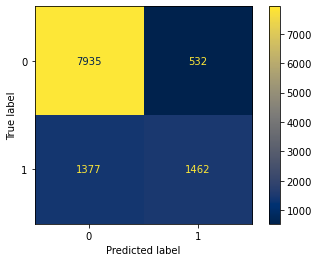

In [77]:
cm = confusion_matrix(y_test, y_pred)

cr = classification_report(y_test, y_pred)
print(cr)
dis = ConfusionMatrixDisplay(cm)
dis.plot(cmap='cividis', values_format='.0f')

In [78]:
# summarize demographic parity using the metric (this gives the exact same result as mf.difference())
dpd = demographic_parity_difference(
    y_true=y_test,  # y_true is ignored
    y_pred=y_pred,
    sensitive_features=X_test["gender"],
    method="between_groups",
)  # summarize as the max difference between any of the groups
print("demographic parity difference: %.2f" % dpd)

demographic parity difference: 0.16


In [79]:
# compute metrics by group
mf = MetricFrame(
    metrics={"selection rate (adult)": selection_rate},
    y_true=y_test,  # is ignored
    y_pred=y_pred,
    sensitive_features=X_test["gender"],
)

# print results
display(mf.by_group)
print("Overall selection rate: %.2f" % mf.overall)

# compute demographic parity as the max difference between groups
print("demographic parity difference: %.2f" % mf.difference(method="between_groups"))

,selection rate (adult)
gender,
0,0.229036
1,0.06481


Overall selection rate: 0.18
demographic parity difference: 0.16


In [80]:
# compute metrics
mf = MetricFrame(
    metrics={
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test[["gender"]],
)
display(mf.by_group)

# print differences
for i in mf.difference("between_groups").iteritems():
    print("%s diff: %.2f" % i)

# alternatively: summarize equalized odds in one metric (which is the max of fpr diff and fnr diff)
dpd = equalized_odds_difference(
    y_test,
    y_pred,
    sensitive_features=X_test["gender"],
    method="between_groups",
)
print("equalized odds diff: %.2f" % dpd)

,false positive rate,false negative rate
gender,,
0,0.08891,0.463617
1,0.019737,0.603687


false positive rate diff: 0.07
false negative rate diff: 0.14
equalized odds diff: 0.14


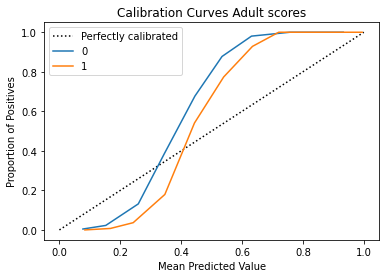

In [81]:
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for gender in [0, 1]:
    prob_true, prob_pred = calibration_curve(
        y_true=y_test[X_test["gender"] == gender],
        y_prob=y_pp[X_test["gender"] == gender],
        n_bins=10,
        normalize=True,
    )
    plt.plot(prob_pred, prob_true, label=gender)
plt.title("Calibration Curves Adult scores")
plt.xlabel("Mean Predicted Value")
plt.ylabel("Proportion of Positives")
plt.legend()
plt.show()

In [82]:
y_train = newdata['income']
X_train = newdata.drop(columns=['income'])

y_test = testset['income']
X_test = testset.drop(columns=['income'])

In [83]:
modelRG.fit(X_train, y_train)

RidgeClassifier(random_state=0)

In [84]:
y_pred = modelRG.predict(X_test)
y_pp = modelRG.decision_function(X_test)

              precision    recall  f1-score   support

           0       0.92      0.78      0.85      8467
           1       0.55      0.81      0.66      2839

    accuracy                           0.79     11306
   macro avg       0.74      0.80      0.75     11306
weighted avg       0.83      0.79      0.80     11306



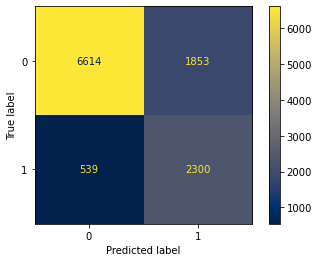

In [85]:
cm = confusion_matrix(y_test, y_pred)

cr = classification_report(y_test, y_pred)
print(cr)
dis = ConfusionMatrixDisplay(cm)
dis.plot(cmap='cividis', values_format='.0f')

In [86]:
# summarize demographic parity using the metric (this gives the exact same result as mf.difference())
dpd = demographic_parity_difference(
    y_true=y_test,  # y_true is ignored
    y_pred=y_pred,
    sensitive_features=X_test["gender"],
    method="between_groups",
)  # summarize as the max difference between any of the groups
print("demographic parity difference: %.2f" % dpd)

demographic parity difference: 0.21


In [87]:
# compute metrics by group
mf = MetricFrame(
    metrics={"selection rate (adult)": selection_rate},
    y_true=y_test,  # is ignored
    y_pred=y_pred,
    sensitive_features=X_test["gender"],
)

# print results
display(mf.by_group)
print("Overall selection rate: %.2f" % mf.overall)

# compute demographic parity as the max difference between groups
print("demographic parity difference: %.2f" % mf.difference(method="between_groups"))

,selection rate (adult)
gender,
0,0.434766
1,0.22449


Overall selection rate: 0.37
demographic parity difference: 0.21


In [88]:
# compute metrics
mf = MetricFrame(
    metrics={
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test[["gender"]],
)
display(mf.by_group)

# print differences
for i in mf.difference("between_groups").iteritems():
    print("%s diff: %.2f" % i)

# alternatively: summarize equalized odds in one metric (which is the max of fpr diff and fnr diff)
dpd = equalized_odds_difference(
    y_test,
    y_pred,
    sensitive_features=X_test["gender"],
    method="between_groups",
)
print("equalized odds diff: %.2f" % dpd)

,false positive rate,false negative rate
gender,,
0,0.263886,0.190437
1,0.144424,0.186636


false positive rate diff: 0.12
false negative rate diff: 0.00
equalized odds diff: 0.12


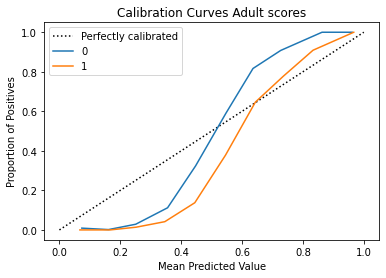

In [89]:
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for gender in [0, 1]:
    prob_true, prob_pred = calibration_curve(
        y_true=y_test[X_test["gender"] == gender],
        y_prob=y_pp[X_test["gender"] == gender],
        n_bins=10,
        normalize=True,
    )
    plt.plot(prob_pred, prob_true, label=gender)
plt.title("Calibration Curves Adult scores")
plt.xlabel("Mean Predicted Value")
plt.ylabel("Proportion of Positives")
plt.legend()
plt.show()